In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

2024-06-13 17:32:04.252270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class TFRForecast:
    def __init__(self, start_year, data_files_path, file_configs, country_name, forecast_steps):
        self.start_year = start_year
        self.data_files_path = data_files_path
        self.file_configs = file_configs
        self.country_name = country_name
        self.cleaned_data = {}
        self.tfr = None
        self.forecast_results = {}
        self.comparison_df = None
        self.rmses = {}
        self.forecast_steps = forecast_steps

    def clean_and_load_data(self, file_path, skip_rows, col_names):
        data = []
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()[skip_rows:]
            for line in lines:
                if line.strip():
                    data.append(line.split())
        df = pd.DataFrame(data)
        df.columns = col_names
        df = df.apply(pd.to_numeric, errors='coerce')
        return df

    def load_data(self):
        for file_name, config in self.file_configs.items():
            file_path = os.path.join(self.data_files_path, file_name)
            self.cleaned_data[file_name] = self.clean_and_load_data(file_path, skip_rows=config['skip_rows'], col_names=config['col_names'])

        asfr_rr = self.cleaned_data[list(self.file_configs.keys())[1]]
        asfr_rr['Age'] = asfr_rr['Age'].apply(self.clean_age)
        asfr_rr['Age'] = pd.to_numeric(asfr_rr['Age'], errors='coerce')
        asfr_rr_agg = asfr_rr.groupby(['Year', 'Age']).agg({'ASFR': 'sum'}).reset_index()
        asfr_rr_filtered = asfr_rr_agg[(asfr_rr_agg['Age'] >= 15) & (asfr_rr_agg['Age'] <= 49)]
        asfr_rr_pivot = asfr_rr_filtered.pivot(index='Year', columns='Age', values='ASFR')
        asfr_rr_pivot = asfr_rr_pivot.fillna(method='ffill').fillna(method='bfill')
        self.tfr = asfr_rr_pivot.sum(axis=1)

    @staticmethod
    def clean_age(age):
        if isinstance(age, str):
            return age.strip('-')
        return age

    @staticmethod
    def create_lstm_data(data, n_lags=1):
        X, y = [], []
        for i in range(len(data) - n_lags):
            X.append(data[i:(i + n_lags)])
            y.append(data[i + n_lags])
        return np.array(X), np.array(y)

    def forecast_tfr(self, tfr, steps=10):
        results = {}

        try:
            model_arima = ARIMA(tfr, order=(5, 1, 0))
            model_fit_arima = model_arima.fit()
            forecast_arima = model_fit_arima.forecast(steps=steps)
            results['ARIMA'] = forecast_arima
        except Exception as e:
            print(f"Failed to fit ARIMA model for TFR: {e}")

        try:
            model_arma = ARIMA(tfr, order=(2, 0, 2))
            model_fit_arma = model_arma.fit()
            forecast_arma = model_fit_arma.forecast(steps=steps)
            results['ARMA'] = forecast_arma
        except Exception as e:
            print(f"Failed to fit ARMA model for TFR: {e}")

        try:
            model_sarima = SARIMAX(tfr, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            model_fit_sarima = model_sarima.fit(disp=False)
            forecast_sarima = model_fit_sarima.forecast(steps=steps)
            results['SARIMA'] = forecast_sarima
        except Exception as e:
            print(f"Failed to fit SARIMA model for TFR: {e}")

        try:
            exog = tfr.shift(1).dropna()
            tfr_aligned = tfr.loc[exog.index]
            exog = exog.values.reshape(-1, 1)
            model_arimax = SARIMAX(tfr_aligned, exog=exog, order=(5, 1, 0))
            model_fit_arimax = model_arimax.fit(disp=False)
            forecast_exog = np.tile(exog[-1], (steps, 1))
            forecast_arimax = model_fit_arimax.forecast(steps=steps, exog=forecast_exog)
            results['ARIMAX'] = forecast_arimax
        except Exception as e:
            print(f"Failed to fit ARIMAX model for TFR: {e}")

        try:
            model_ets = ExponentialSmoothing(tfr, seasonal='add', seasonal_periods=12)
            model_fit_ets = model_ets.fit()
            forecast_ets = model_fit_ets.forecast(steps=steps)
            results['ETS'] = forecast_ets
        except Exception as e:
            print(f"Failed to fit ETS model for TFR: {e}")

        try:
            n_lags = 3
            X, y = self.create_lstm_data(tfr.values, n_lags=n_lags)
            X = X.reshape((X.shape[0], X.shape[1], 1))
            lstm_model = Sequential()
            lstm_model.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))
            lstm_model.add(Dense(1))
            lstm_model.compile(optimizer='adam', loss='mse')
            lstm_model.fit(X, y, epochs=200, verbose=0)
            lstm_input = tfr.values[-n_lags:].reshape((1, n_lags, 1))
            lstm_forecast = []
            for _ in range(steps):
                lstm_pred = lstm_model.predict(lstm_input, verbose=0)
                lstm_forecast.append(lstm_pred[0, 0])
                lstm_input = np.append(lstm_input[:, 1:, :], lstm_pred).reshape((1, n_lags, 1))
            results['LSTM'] = pd.Series(lstm_forecast, index=range(int(tfr.index[-1]) + 1, int(tfr.index[-1]) + 1 + steps))
        except Exception as e:
            print(f"Failed to fit LSTM model for TFR: {e}")

        return results

    @staticmethod
    def calculate_rmse(actual, predicted):
        return np.sqrt(((predicted - actual) ** 2).mean())

    def run_analysis(self):
        self.load_data()

        historical_tfr = self.tfr[self.tfr.index < self.start_year]
        self.forecast_results = self.forecast_tfr(historical_tfr, steps=self.forecast_steps)

        forecast_index = range(self.start_year, self.start_year + self.forecast_steps)
        forecast_df = pd.DataFrame({'Year': forecast_index})

        historical_tfr_df = pd.DataFrame(self.tfr).reset_index()
        historical_tfr_df.columns = ['Year', 'Historical TFR']

        for model, forecast in self.forecast_results.items():
            forecast_df[model] = forecast.values

        self.comparison_df = pd.merge(historical_tfr_df, forecast_df, on='Year', how='outer')

        plt.figure(figsize=(12, 8))
        plt.plot(historical_tfr_df['Year'], historical_tfr_df['Historical TFR'], label='Historical TFR', color='blue')
        for model, forecast in self.forecast_results.items():
            plt.plot(forecast_index, forecast, label=f'Forecast ({model})')

        plt.xlabel('Year')
        plt.ylabel('TFR')
        plt.title(f'Total Fertility Rate (TFR) and Forecasts {self.country_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Comparison of Forecasted Values:")
        print(self.comparison_df[-self.forecast_steps:-1])

        actual = self.comparison_df.loc[self.comparison_df['Year'] >= self.start_year, 'Historical TFR']
        for model in self.forecast_results.keys():
            predicted = self.comparison_df.loc[self.comparison_df['Year'] >= self.start_year, model]
            self.rmses[model] = self.calculate_rmse(actual, predicted)
        
        for model, rmse in self.rmses.items():
            print(f"RMSE for {model}: {rmse}")

        best_model = min(self.rmses, key=self.rmses.get)
        print(f"The best model based on RMSE is: {best_model}")

        return best_model, self.rmses

2024-06-13 17:32:08.017762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


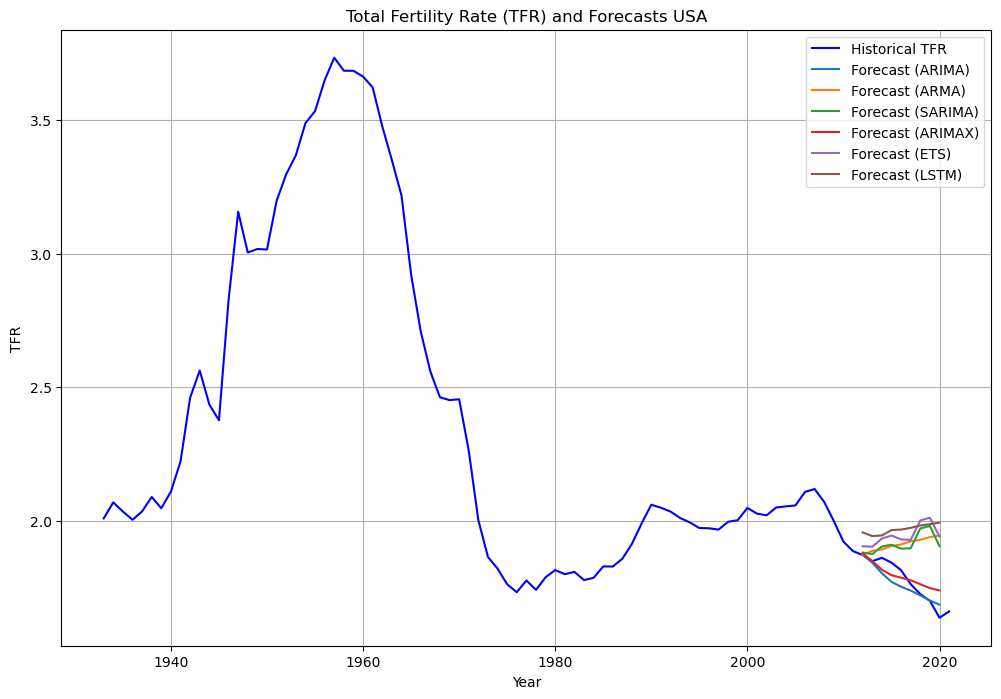

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
80  2013.0         1.84920  1.843757  1.887666  1.875694  1.849430  1.903554   
81  2014.0         1.86182  1.804031  1.893145  1.904376  1.817511  1.933812   
82  2015.0         1.84357  1.772077  1.906036  1.910697  1.796699  1.945159   
83  2016.0         1.81542  1.753478  1.911853  1.896059  1.787367  1.930969   
84  2017.0         1.76318  1.739295  1.923293  1.897321  1.778066  1.928517   
85  2018.0         1.72602  1.721258  1.929264  1.971872  1.762838  2.001948   
86  2019.0         1.70055  1.701751  1.939489  1.980775  1.748438  2.011805   
87  2020.0         1.63762  1.686417  1.945478  1.905419  1.739794  1.940501   

        LSTM  
80  1.943070  
81  1.945517  
82  1.965427  
83  1.967421  
84  1.973900  
85  1.982773  
86  1.987679  
87  1.993508  
RMSE for ARIMA: 0.04122215050555726
RMSE for ARMA: 0.16140897515542568
RMSE for SARIMA: 0.16407551121376018
RMS

In [3]:
data_files_path_usa = 'data/USA/20230328/'

file_configs_usa = {
    'USApprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'USAasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'USAasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'USAasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'USAasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'USAasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'USAasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'USAasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_usa = TFRForecast(start_year=2012, data_files_path=data_files_path_usa, file_configs=file_configs_usa, country_name="USA", forecast_steps=9)
best_model, rmses = tfr_forecast_usa.run_analysis()


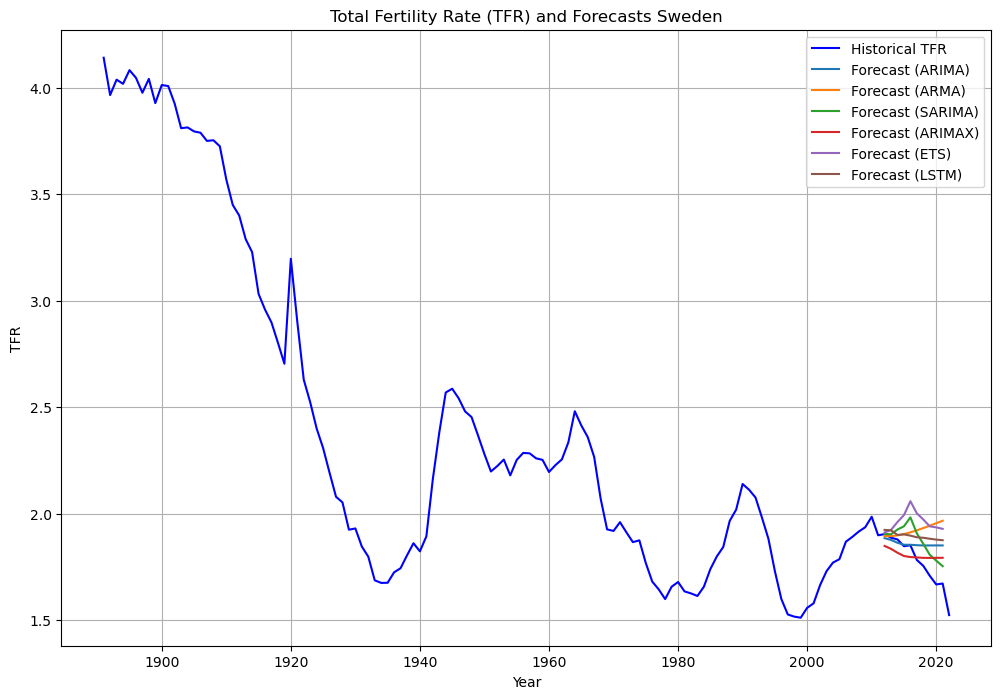

Comparison of Forecasted Values:
       Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
122  2013.0         1.88752  1.877359  1.895218  1.904030  1.835597  1.924660   
123  2014.0         1.87984  1.864050  1.898743  1.926440  1.817243  1.961718   
124  2015.0         1.84792  1.854768  1.904951  1.941360  1.801828  1.994045   
125  2016.0         1.85238  1.854592  1.913089  1.983441  1.797204  2.059239   
126  2017.0         1.78314  1.852662  1.922601  1.907862  1.795174  2.002220   
127  2018.0         1.75560  1.851437  1.933072  1.858879  1.793273  1.973206   
128  2019.0         1.70891  1.851488  1.944198  1.807606  1.792973  1.941112   
129  2020.0         1.66851  1.851638  1.955750  1.780193  1.793338  1.936521   
130  2021.0         1.67278  1.851527  1.967562  1.754071  1.793500  1.929447   

         LSTM  
122  1.922323  
123  1.900820  
124  1.903458  
125  1.897488  
126  1.890000  
127  1.887534  
128  1.883048  
129  1.878991  
130  1.87608

In [4]:
data_files_path_swe = 'data/SWE/20230414/'

file_configs_swe = {
    'SWEpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'SWEasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'SWEasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'SWEasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'SWEasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'SWEasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'SWEasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'SWEasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_swe = TFRForecast(start_year=2012, data_files_path=data_files_path_swe, file_configs=file_configs_swe, country_name="Sweden", forecast_steps=10)
best_model, rmses = tfr_forecast_swe.run_analysis()


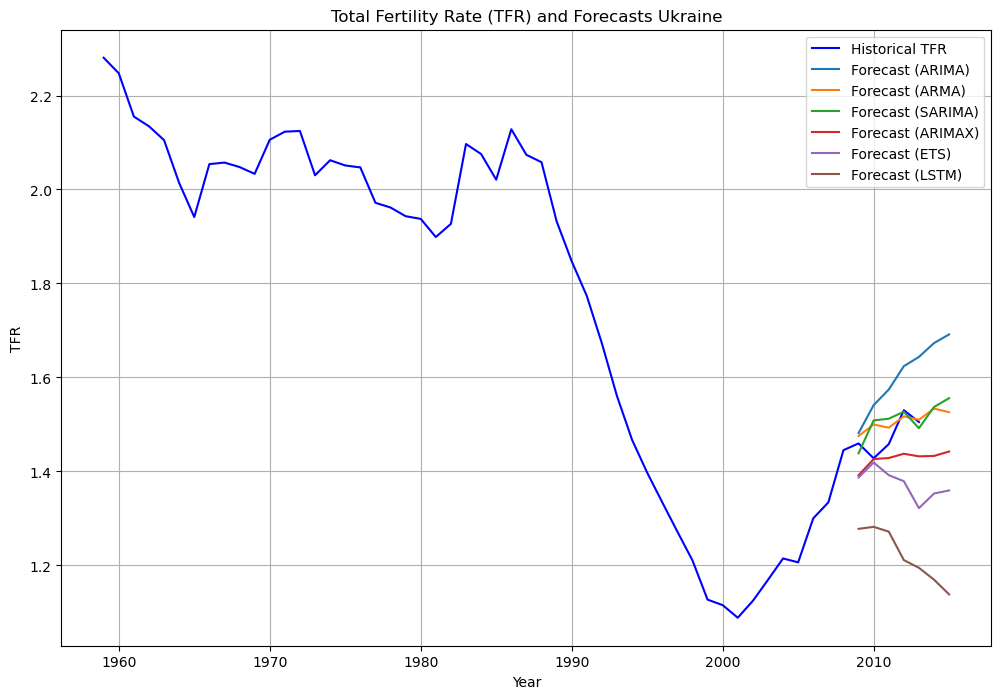

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
50  2009.0         1.45958  1.481471  1.475303  1.438592  1.391754  1.387040   
51  2010.0         1.42796  1.541109  1.499900  1.508511  1.426301  1.419038   
52  2011.0         1.45798  1.574161  1.493034  1.512125  1.428492  1.392089   
53  2012.0         1.53036  1.623940  1.517210  1.527030  1.437566  1.379169   
54  2013.0         1.50516  1.643658  1.509948  1.491985  1.432067  1.321852   
55  2014.0             NaN  1.673150  1.533721  1.537142  1.432933  1.352918   

        LSTM  
50  1.277768  
51  1.282037  
52  1.271929  
53  1.211249  
54  1.194887  
55  1.169596  
RMSE for ARIMA: 0.10461252871645284
RMSE for ARMA: 0.03700593266401938
RMSE for SARIMA: 0.04482247902368429
RMSE for ARIMAX: 0.062331332217799955
RMSE for ETS: 0.11501637150906216
RMSE for LSTM: 0.23961006453143238
The best model based on RMSE is: ARMA


In [5]:
data_files_path_ukr = 'data/UKR/20160118/'

file_configs_ukr = {
    'UKRpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'UKRasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'UKRasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'UKRasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'UKRasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'UKRasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'UKRasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'UKRasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_ukr = TFRForecast(start_year=2009, data_files_path=data_files_path_ukr, file_configs=file_configs_ukr, country_name="Ukraine", forecast_steps=7)
best_model, rmses = tfr_forecast_ukr.run_analysis()


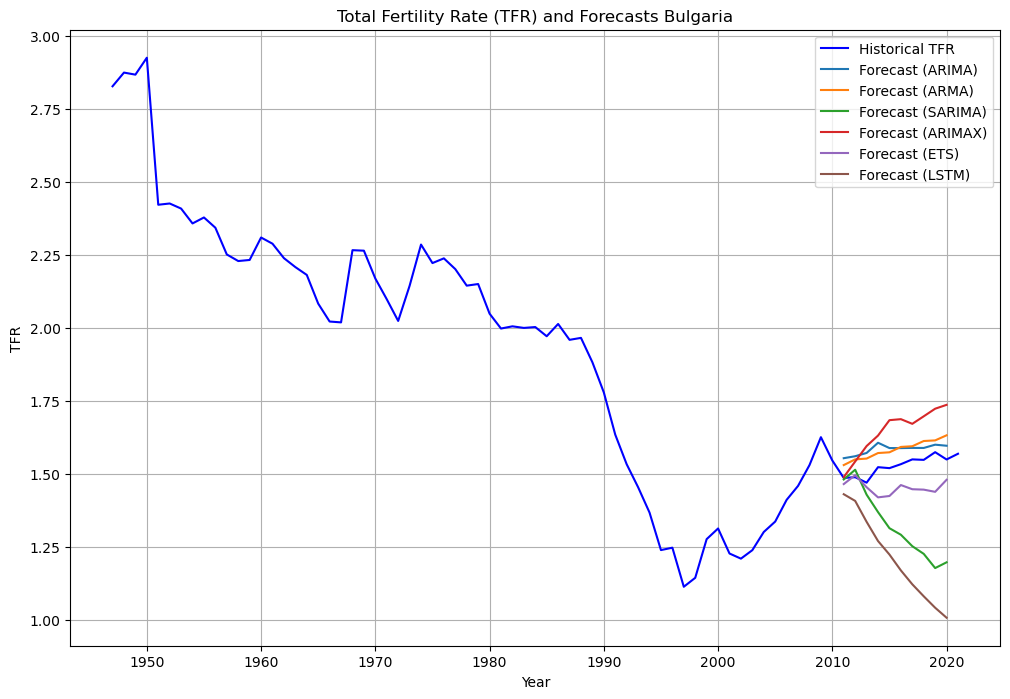

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
65  2012.0         1.48949  1.561238  1.550433  1.515057  1.543130  1.496449   
66  2013.0         1.47074  1.572411  1.553204  1.429795  1.596037  1.455270   
67  2014.0         1.52378  1.607323  1.572130  1.370164  1.631891  1.420503   
68  2015.0         1.52050  1.589144  1.574665  1.315011  1.684580  1.425229   
69  2016.0         1.53402  1.589020  1.593072  1.292692  1.688013  1.462643   
70  2017.0         1.55042  1.589701  1.595381  1.253515  1.672076  1.448352   
71  2018.0         1.54879  1.589534  1.613285  1.227254  1.697802  1.446960   
72  2019.0         1.57511  1.600735  1.615379  1.178650  1.723785  1.439471   
73  2020.0         1.55013  1.597118  1.632795  1.198343  1.737009  1.480653   

        LSTM  
65  1.408409  
66  1.336884  
67  1.271144  
68  1.224946  
69  1.170630  
70  1.123122  
71  1.082115  
72  1.042975  
73  1.008815  
RMSE for ARIMA: 

In [6]:
data_files_path_bgr = 'data/BGR/20230307/'

file_configs_bgr = {
    'BGRpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'BGRasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'BGRasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'BGRasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'BGRasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'BGRasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'BGRasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'BGRasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_isl = TFRForecast(start_year=2011, data_files_path=data_files_path_bgr, file_configs=file_configs_bgr, country_name="Bulgaria", forecast_steps=10)
best_model, rmses = tfr_forecast_isl.run_analysis()


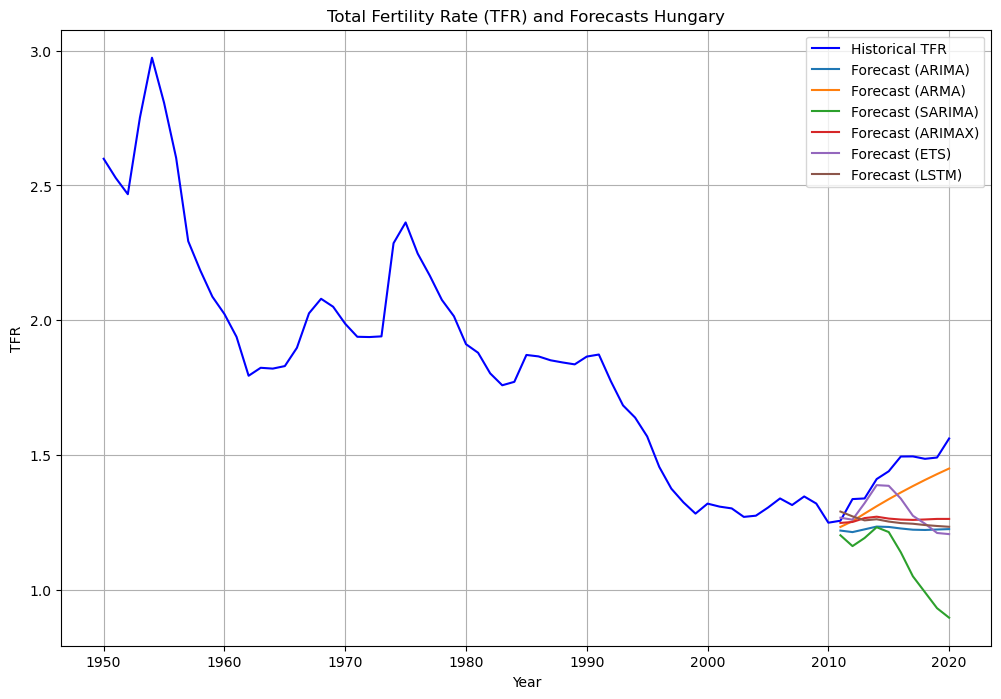

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
61  2011.0         1.25612  1.219613  1.233100  1.202128  1.247916  1.267305   
62  2012.0         1.33641  1.213950  1.254492  1.162027  1.251518  1.260010   
63  2013.0         1.33881  1.224116  1.282639  1.192072  1.265910  1.321243   
64  2014.0         1.41067  1.234391  1.309935  1.232042  1.271091  1.388168   
65  2015.0         1.43961  1.233048  1.336020  1.214071  1.264121  1.385652   
66  2016.0         1.49434  1.227349  1.360927  1.139002  1.260543  1.338098   
67  2017.0         1.49474  1.222846  1.384709  1.049895  1.259188  1.274593   
68  2018.0         1.48579  1.221840  1.407415  0.990870  1.260819  1.245108   
69  2019.0         1.49060  1.223529  1.429095  0.931632  1.262859  1.210674   

        LSTM  
61  1.290179  
62  1.272294  
63  1.257464  
64  1.261588  
65  1.252962  
66  1.247429  
67  1.244947  
68  1.240160  
69  1.236607  
RMSE for ARIMA: 

In [7]:
data_files_path_hun = 'data/HUN/20220314/'

file_configs_hun = {
    'HUNpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'HUNasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'HUNasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'HUNasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'HUNasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'HUNasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'HUNasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'HUNasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_rus = TFRForecast(start_year=2011, data_files_path=data_files_path_hun, file_configs=file_configs_hun, country_name="Hungary", forecast_steps=10)
best_model, rmses = tfr_forecast_rus.run_analysis()


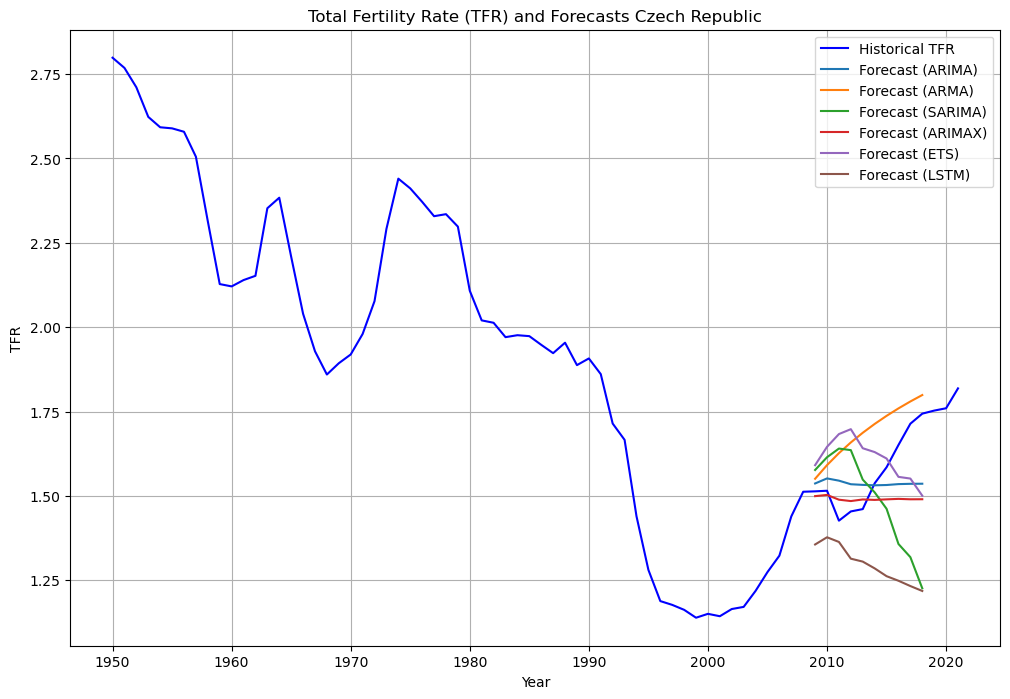

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
62  2012.0         1.45419  1.534763  1.658562  1.635784  1.484899  1.697882   
63  2013.0         1.46109  1.532859  1.687212  1.548451  1.489651  1.641403   
64  2014.0         1.53742  1.531574  1.713337  1.510729  1.488333  1.630056   
65  2015.0         1.58499  1.532458  1.737326  1.462068  1.489945  1.610988   
66  2016.0         1.65106  1.535132  1.759468  1.357735  1.491366  1.556578   
67  2017.0         1.71409  1.535995  1.779986  1.318673  1.490135  1.551568   
68  2018.0         1.74388  1.536264  1.799054  1.226334  1.490312  1.500783   
69  2019.0         1.75294       NaN       NaN       NaN       NaN       NaN   
70  2020.0         1.75986       NaN       NaN       NaN       NaN       NaN   

        LSTM  
62  1.314213  
63  1.305551  
64  1.285486  
65  1.262371  
66  1.248787  
67  1.233077  
68  1.218523  
69       NaN  
70       NaN  
RMSE for ARIMA: 

In [8]:
data_files_path_cze = 'data/CZE/20230307/'

file_configs_cze = {
    'CZEpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'CZEasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'CZEasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'CZEasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'CZEasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'CZEasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'CZEasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'CZEasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_cze = TFRForecast(start_year=2009, data_files_path=data_files_path_cze, file_configs=file_configs_cze, country_name="Czech Republic", forecast_steps=10)
best_model, rmses = tfr_forecast_cze.run_analysis()


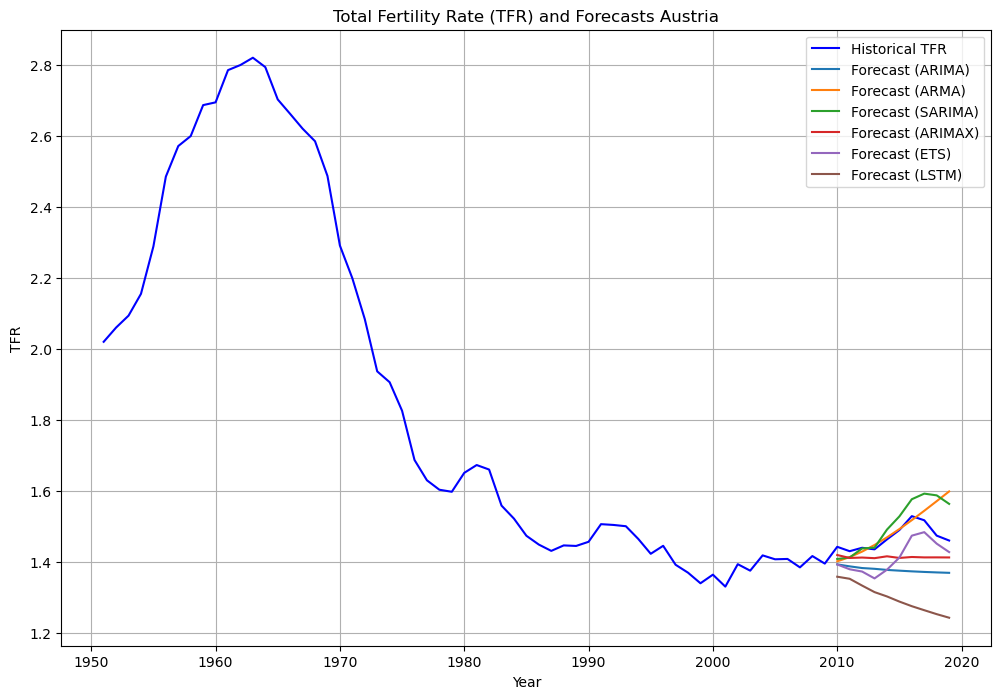

Comparison of Forecasted Values:
      Year  Historical TFR     ARIMA      ARMA    SARIMA    ARIMAX       ETS  \
59  2010.0         1.44276  1.393295  1.401940  1.408570  1.419661  1.393013   
60  2011.0         1.43043  1.387721  1.413738  1.412655  1.411345  1.379501   
61  2012.0         1.44002  1.382955  1.429247  1.438152  1.412536  1.373091   
62  2013.0         1.43559  1.380785  1.447937  1.440451  1.410769  1.353765   
63  2014.0         1.46365  1.377664  1.469286  1.491264  1.416021  1.378244   
64  2015.0         1.49008  1.375577  1.492784  1.528484  1.411416  1.412493   
65  2016.0         1.52912  1.373621  1.517938  1.576850  1.414086  1.474200   
66  2017.0         1.51753  1.371976  1.544277  1.592577  1.412932  1.484049   
67  2018.0         1.47425  1.370637  1.571357  1.587702  1.412999  1.451639   

        LSTM  
59  1.358539  
60  1.352712  
61  1.333559  
62  1.315153  
63  1.302953  
64  1.288461  
65  1.275462  
66  1.264165  
67  1.253067  
RMSE for ARIMA: 

In [9]:
data_files_path_aut = 'data/AUT/20210825/'

file_configs_aut = {
    'AUTpprVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'PPR0_1', 'PPR1_2', 'PPR2_3', 'PPR3_4']},
    'AUTasfrRR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR']},
    'AUTasfrTR.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'Cohort', 'ASFR']},
    'AUTasfrVH.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR']},
    'AUTasfrVV.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR']},
    'AUTasfrRRbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'AUTasfrVHbo.txt': {'skip_rows': 2, 'col_names': ['Cohort', 'Age', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']},
    'AUTasfrVVbo.txt': {'skip_rows': 2, 'col_names': ['Year', 'ARDY', 'Cohort', 'ASFR', 'ASFR1', 'ASFR2', 'ASFR3', 'ASFR4', 'ASFR5p']}
}
tfr_forecast_aut = TFRForecast(start_year=2010, data_files_path=data_files_path_aut, file_configs=file_configs_aut, country_name="Austria", forecast_steps=10)
best_model, rmses = tfr_forecast_aut.run_analysis()
